In [0]:
# -*- coding: utf-8 -*-
"""
Created on 30 May 2023
File: emotion_webcam_demo.py
Author: Bibin Kunjumon
Description: Real-time Emotion Classification Demo using Webcam
"""
from tensorflow.keras import models
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
# import trained_models 

#Importing the model
trained_model = models.load_model("/dbfs/FileStore/demo_store/built_model/trained_vggface.h5", compile=False)
# trained_model = models.load_model('../trained_models/weights-improvement-04-2.015.h5', compile=False) 
trained_model.summary()
# prevents openCL usage and unnecessary logging messages




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 96, 96, 64)        1792      
                                                                 
 conv1_2 (Conv2D)            (None, 96, 96, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 48, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 48, 48, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 48, 48, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 24, 128)       0   

In [0]:
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_generator(train_dir, valid_dir, test_dir, train_label, valid_label, test_label):
    # Add our data-augmentation parameters to ImageDataGenerator
    train_datagen = ImageDataGenerator(#rescale = 1./255.,
                                       rotation_range = 40,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
    
    # Note that the validation data should not be augmented!
    valid_datagen = ImageDataGenerator()#rescale = 1./255. )
    test_datagen = ImageDataGenerator()#rescale = 1./255. )
    
    # Flow training images in batches of 5 using train_datagen generator
    train_generator=train_datagen.flow_from_dataframe(dataframe=train_label,
                                                     directory=train_dir,
                                                     x_col="id",
                                                     y_col="emotion",
                                                     target_size=(96,96),
                                                     batch_size=32,
                                                     seed=42,
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     color_mode='rgb')
    # train_generator=itertools.islice(itertools.cycle(train_generator),896)#By using itertools.cycle() and itertools.islice(), you can achieve a similar effect to the .repeat()
    # train_generator=train_generator.repeat() // I deleted steps_per_epoch

    
    # # Flow validation images in batches of 5 using test_datagen generator
    valid_generator=valid_datagen.flow_from_dataframe(dataframe=valid_label,
                                                      directory=valid_dir,
                                                      x_col="id",
                                                      y_col="emotion",
                                                      target_size=(96,96),
                                                      batch_size=32,
                                                      seed=42,
                                                      shuffle=True,
                                                      class_mode="categorical",
                                                      color_mode='rgb')
    
    # valid_generator=itertools.islice(itertools.cycle(valid_generator),896)#By using itertools.cycle() and itertools.islice(), you can achieve a similar effect to the .repeat()
    # valid_generator=valid_generator.repeat() I deleted steps_per_valid
    # Flow validation images in batches of 5 using test_datagen generator
    test_generator=test_datagen.flow_from_dataframe(dataframe=test_label,
                                                     directory=test_dir,
                                                     x_col="id",
                                                     y_col=None,
                                                     target_size=(96,96),
                                                     batch_size=32,
                                                     seed=42,
                                                     shuffle=False,
                                                     class_mode=None,
                                                     color_mode='rgb')

    return train_generator, valid_generator, test_generator


# -*- coding: utf-8 -*-
"""
Created on 30 May 2023

Author: Bibin Kunjumon
"""

def append_ext(fn):
    return fn+".jpg"

# -*- coding: utf-8 -*-
"""
Created on 30 May 2023
File: label_and_dir.py
Author: Bibin Kunjumon

"""

def label_and_dir():
    # Load the dataset
    data_set_path = "/FileStore/demo_store/traininglabel.csv"
    train_label_spark = spark.read.csv(data_set_path,header=True,inferSchema=True)
    train_label = train_label_spark.toPandas().astype(str)

    data_set_path = "/FileStore/demo_store/publictestlabel.csv"
    valid_label_spark = spark.read.csv(data_set_path,header=True,inferSchema=True)
    valid_label = valid_label_spark.toPandas().astype(str)

    data_set_path = "/FileStore/demo_store/privatetestlabel.csv"
    test_label_spark = spark.read.csv(data_set_path,header=True,inferSchema=True)
    test_label = test_label_spark.toPandas().astype(str)


    # train_label = pd.read_csv('/FileStore/demo_store/traininglabel.csv',dtype=str)
    # valid_label = pd.read_csv('/FileStore/demo_store/publictestlabel.csv',dtype=str)
    # test_label = pd.read_csv('/FileStore/demo_store/privatetestlabel.csv',dtype=str)
    
    train_label["id"]=train_label["id"].apply(append_ext)
    valid_label["id"]=valid_label["id"].apply(append_ext)
    test_label["id"]=test_label["id"].apply(append_ext)
    
    # Define our example directories and files
    train_dir = '/FileStore/demo_store/Training'
    valid_dir = '/FileStore/demo_store/PublicTest'
    test_dir = '/FileStore/demo_store/PrivateTest'
    return train_dir, valid_dir, test_dir, train_label, valid_label, test_label

train_dir, valid_dir, test_dir, train_label, valid_label, test_label = label_and_dir()
train_generator, valid_generator, test_generator = data_generator(train_dir, valid_dir, test_dir, train_label, valid_label, test_label)

Found 28709 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames.


In [0]:
#prediction
predictions = trained_model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

print("Predictions\n",predicted_labels,"\nLength = ",len(predicted_labels))

true_labels = test_label['emotion'].astype(int).values

print("True Labels\n",true_labels,"\nLength = ",len(true_labels))

from sklearn.metrics import f1_score, confusion_matrix
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("\n****F1 Score****\n")
print(f1)
# mlflow.log_metric("f1score",f1)

cm = confusion_matrix(true_labels, predicted_labels)
print("\n****Confusion_Matrix****\n")
print(cm)

print("-"*20)


113/113 [==============================] - 234s 2s/step
Predictions
 [0 4 4 ... 0 3 4] 
Length =  3589
True Labels
 [0 5 6 ... 0 3 2] 
Length =  3589

****F1 Score****

0.5526495663759212

****Confusion_Matrix****

[[229   3  31  33 109  12  74]
 [ 18  13   8   2  10   2   2]
 [ 70   4 141  31 154  70  58]
 [  6   0  13 795  23  15  27]
 [ 39   1  37  43 336   9 129]
 [  8   1  38  40   9 303  17]
 [ 11   2  22  40 113  29 409]]
--------------------


In [0]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: 'Neutral'}
f1_scores = f1_score(true_labels, predicted_labels, average=None)
print("F1 Scores for Each Emotion:\n")
count=0
for emotion in emotion_dict:
    print(emotion_dict.get(emotion),":",f1_scores[count])
    count +=1



F1 Scores for Each Emotion:

Angry : 0.5252293577981652
Disgust : 0.32911392405063294
Fear : 0.34474327628361856
Happy : 0.8534621578099839
Sad : 0.49851632047477745
Surprise : 0.7079439252336448
Neutral : 0.6095380029806259


In [0]:
cv2.ocl.setUseOpenCL(False)
# dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: 'Neutral'}
detector = MTCNN()
# start the webcam feed
cap = cv2.VideoCapture(0)
black = np.zeros((96,96))

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
	# detect faces in the image
    results = detector.detect_faces(frame)
	# extract the bounding box from the first face
    if len(results) == 1: #len(results)==1 if there is a face detected. len ==0 if no face is detected
        try:
            x1, y1, width, height = results[0]['box']
            x2, y2 = x1 + width, y1 + height
        	# extract the face
            face = frame[y1:y2, x1:x2]
            #Draw a rectangle around the face
            cv2.rectangle(frame, (x1, y1), (x1+width, y1+height), (255, 0, 0), 2)
            # resize pixels to the model size
            cropped_img = cv2.resize(face, (96,96)) 
            cropped_img_expanded = np.expand_dims(cropped_img, axis=0)
            cropped_img_float = cropped_img_expanded.astype(float)
            prediction = trained_model.predict(cropped_img_float)
            print(prediction)
            maxindex = int(np.argmax(prediction))
            print("*****",maxindex,"******") # it is the emotion index in dictionary
            cv2.putText(frame, emotion_dict[maxindex], (x1+20, y1-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        except:
            pass
    cv2.imshow('Video',frame)
    try:
        cv2.imshow("frame", cropped_img)
    except:
        cv2.imshow("frame", black)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

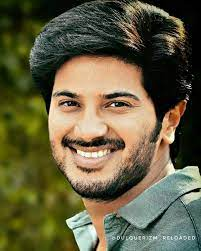

1/1 [==============================] - 0s 191ms/step
***** 3 ******
Predicted Label: 3 Happy


In [0]:
#predict single image:

import cv2
from dbruntime.patches import cv2_imshow
image_path = "/dbfs/FileStore/demo_store/dq.jpeg"
img = cv2.imread(image_path)
cv2_imshow(img)
cropped_img = cv2.resize(img, (96,96)) 
cropped_img_expanded = np.expand_dims(cropped_img, axis=0)
cropped_img_float = cropped_img_expanded.astype(float)
prediction = trained_model.predict(cropped_img_float)
predicted_label = int(np.argmax(prediction))
print("*****",predicted_label,"******") # it is the emotion index in dictionary
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: 'Neutral'}
print("Predicted Label:", predicted_label,emotion_dict.get(predicted_label))

In [0]:
import mlflow

In [0]:
# mlflow.register_model(model_uri="dbfs:/FileStore/demo_store/built_model/",name="VGGFACE-MyModel3")